## Language Translation Hieroglyphics - De

In [1]:
import logging
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import torch
from collections import Counter
from torchtext.vocab import Vocab
from Hiero_tokenizer import CustomMosesTokenizer
from De_tokenizer import DEMosesTokenizer
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import io
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from collections import Counter
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   #TODO craamming

['jri̯', '[', 'n', ']', '=', '[', 'n', ']', '[', 'm', ']', 'w', '[', 'ḏ', ']', '.', 'n', '=k', 'nb']
['Handle', 'du', 'für', 'uns', 'entsprechend', 'all', 'dem', 'was', 'du', 'befiehlst!']


## Data Processing

In [2]:
# Load the 'bbaw_egyptian' dataset
dataset = load_dataset("bbaw_egyptian")

source_tokenizer = CustomMosesTokenizer()
target_tokenizer = DEMosesTokenizer()

source_texts = [text['transcription'] for text in dataset['train'] if 'transcription' in text and text['transcription'] is not None]
target_texts = [text['translation'] for text in dataset['train'] if 'translation' in text and text['translation'] is not None]

source_texts = []
target_texts = []

for instance in dataset['train']:
    if 'transcription' in instance and instance['transcription'] is not None and \
       'translation' in instance and instance['translation'] is not None:
        source_texts.append(instance['transcription'])
        target_texts.append(instance['translation'])

# Apply only one-fifth of the dataset
fifth_of_data = len(source_texts) // 10   # or any other value, depending on available memory
source_texts = source_texts[:fifth_of_data]
target_texts = target_texts[:fifth_of_data]

# Split the data into train, validation, and test sets
source_train, source_temp, target_train, target_temp = train_test_split(source_texts, target_texts, test_size=0.3, random_state=42)
source_val, source_test, target_val, target_test = train_test_split(source_temp, target_temp, test_size=0.5, random_state=42)

# Tokenize the source and target texts
source_tokenized_train = [source_tokenizer.tokenize(text) for text in source_train]
target_tokenized_train = [target_tokenizer.tokenize(text) for text in target_train]

source_tokenized_val = [source_tokenizer.tokenize(text) for text in source_val]
target_tokenized_val = [target_tokenizer.tokenize(text) for text in target_val]

source_tokenized_test = [source_tokenizer.tokenize(text) for text in source_test]
target_tokenized_test = [target_tokenizer.tokenize(text) for text in target_test]

# Example output
print("Original source text:", source_texts[0])
print("Tokenized source text:", source_tokenized_train[0])
print("Original target text:", target_texts[0])
print("Tokenized target text:", target_tokenized_train[0])


Found cached dataset bbaw_egyptian (C:/Users/wuqif/.cache/huggingface/datasets/bbaw_egyptian/default/0.0.0/3807b2d4f38732b2929b7197d2dff9035948ce29fcc6139b7bbc850c2f952f52)


  0%|          | 0/1 [00:00<?, ?it/s]

Original source text: ⸢pḏ,wt-9⸣   n =f   [⸮ḥtr?]   ⸢m⸣  
Tokenized source text: ['nn', '-', 'wn{n}', '{f}ḫ〈ft〉,y', '.', 'w', '.', 'pl', 'm', 'r', '(', 'm', ')', 'ṯ', '.', 'pl', 'nṯr', '.', 'pl', 'ꜣḫ', '.', 'pl', 'mwt', '.', 'pl', 'm', '(', 'j', ')', 'ḫ,t', 'nb', '(', '.', 't', ')', 'm', 'tꜣ', 'pn', 'r', '-', 'ḏr', '=f']
Original target text: ... die Neun-Bogenvölker ... zu ihm ... Pferdegespann ...
Tokenized target text: ['Es', 'gib', 'keine', 'Gegner', 'unter', 'den', 'Menschen', 'den', 'Göttern', 'den', 'Verklärten', 'den', 'Toten', 'in', 'allen', 'Dingen', 'und', 'in', 'diesem', 'ganzen', 'Land']


In [ ]:
def build_vocab(tokenizer, texts, min_freq=1):
    counter = Counter()
    for text in texts:
        tokens = tokenizer.tokenize(text)
        counter.update(tokens)

    vocab = ['<pad>', '<s>', '</s>', '<unk>'] + [token for token, freq in counter.items() if freq >= min_freq]
    token_to_idx = {token: idx for idx, token in enumerate(vocab)}
    idx_to_token = {idx: token for token, idx in token_to_idx.items()}

    return vocab, token_to_idx, idx_to_token

source_vocab, source_token_to_idx, source_idx_to_token = build_vocab(source_tokenizer, source_texts)
target_vocab, target_token_to_idx, target_idx_to_token = build_vocab(target_tokenizer, target_texts)

input_vocab_size = len(source_vocab)
output_vocab_size = len(target_vocab)  #around 1m

## DataLoader

In [ ]:
# Load the 'bbaw_egyptian' dataset
dataset = load_dataset("bbaw_egyptian")

source_tokenizer = CustomMosesTokenizer()
target_tokenizer = DEMosesTokenizer()

source_texts = []
target_texts = []

for instance in dataset['train']:
    if 'transcription' in instance and instance['transcription'] is not None and \
       'translation' in instance and instance['translation'] is not None:
        source_texts.append(instance['transcription'])
        target_texts.append(instance['translation'])

# Apply only one-fifth of the dataset
fifth_of_data = len(source_texts) // 10
source_texts = source_texts[:fifth_of_data]
target_texts = target_texts[:fifth_of_data]

def remove_special_chars(text):
    return text.replace('[', '').replace(']', '').replace(',', '').replace('.', '').replace('§','').replace('(','').replace(')','')

# Modify the target_texts list to remove the special characters
target_texts = [remove_special_chars(text) for text in target_texts]

source_train, source_temp, target_train, target_temp = train_test_split(source_texts, target_texts, test_size=0.3, random_state=42)
source_val, source_test, target_val, target_test = train_test_split(source_temp, target_temp, test_size=0.5, random_state=42)

source_vocab, source_token_to_idx, source_idx_to_token = build_vocab(source_tokenizer, source_texts)
target_vocab, target_token_to_idx, target_idx_to_token = build_vocab(target_tokenizer, target_texts)

def tokens_to_indices(tokenizer, token_to_idx, texts):
    tokenized_texts = [tokenizer.tokenize(text) for text in texts]
    return [[token_to_idx[token] if token in token_to_idx else token_to_idx['<unk>'] for token in tokens] for tokens in tokenized_texts]

train_data = list(zip(tokens_to_indices(source_tokenizer, source_token_to_idx, source_train),
                      tokens_to_indices(target_tokenizer, target_token_to_idx, target_train)))
val_data = list(zip(tokens_to_indices(source_tokenizer, source_token_to_idx, source_val),
                    tokens_to_indices(target_tokenizer, target_token_to_idx, target_val)))
test_data = list(zip(tokens_to_indices(source_tokenizer, source_token_to_idx, source_test),
                     tokens_to_indices(target_tokenizer, target_token_to_idx, target_test)))

BATCH_SIZE = 128        #Original is BATCH_SIZE = 128, decreasing the batch size can help avoid running out of memory. However, it may also lead to a slower training process and might affect the final model performance.

PAD_IDX = target_token_to_idx['<pad>']
BOS_IDX = target_token_to_idx['<s>']
EOS_IDX = target_token_to_idx['</s>']

def generate_batch(data_batch):
    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
        de_batch.append(torch.cat([torch.tensor([BOS_IDX]), torch.tensor(de_item), torch.tensor([EOS_IDX])], dim=0))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), torch.tensor(en_item), torch.tensor([EOS_IDX])], dim=0))
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
    return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

Found cached dataset bbaw_egyptian (C:/Users/wuqif/.cache/huggingface/datasets/bbaw_egyptian/default/0.0.0/3807b2d4f38732b2929b7197d2dff9035948ce29fcc6139b7bbc850c2f952f52)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def print_examples(source_texts, target_texts, num_examples=3):
    print("> Examples in source language:")
    for i in range(num_examples):
        print(source_texts[i])
    print()

    print("> Examples in target language:")
    for i in range(num_examples):
        print(target_texts[i])

# Call the function to print examples
print_examples(source_train, target_train)

> Examples in source language:
nn-wn{n} {f}ḫ〈ft〉,y.w.pl m r(m)ṯ.pl nṯr.pl ꜣḫ.pl mwt.pl m (j)ḫ,t nb(.t) m  tꜣ pn r-ḏr =f
ḫnd =k ḥr =f ⸮ḥꜣ,t(j).w? 
[⸮jri̯?] =f 

> Examples in target language:
Es gib keine Gegner unter den Menschen, den Göttern, den Verklärten, den Toten, in allen Dingen und in diesem ganzen Land.
[...] wenn du trittst auf ihn, die Herzen (?) [...]
(und) er [⸮setzte?] ...


In [ ]:

# Tokenize examples from target_train
tokenized_examples = [target_tokenizer.tokenize(example) for example in target_train[:3]]

print("> This is a batch of strings:")
for example in target_train[:3]:
    print(example)
print()

# Tokenize and convert to token IDs
encoded = tokens_to_indices(target_tokenizer, target_token_to_idx, target_train[:3])

print("> This is a padded-batch of token IDs:")
for row in encoded:
    print(row)

> This is a batch of strings:
Es gib keine Gegner unter den Menschen, den Göttern, den Verklärten, den Toten, in allen Dingen und in diesem ganzen Land.
[...] wenn du trittst auf ihn, die Herzen (?) [...]
(und) er [⸮setzte?] ...

> This is a padded-batch of token IDs:
[276, 5649, 2651, 2389, 102, 131, 835, 34, 131, 1393, 34, 131, 7899, 34, 131, 463, 34, 150, 308, 3835, 81, 150, 147, 2173, 168, 27]
[10, 4, 12, 523, 59, 11574, 93, 154, 34, 5, 225, 20, 126, 22, 10, 4, 12]
[20, 81, 22, 73, 10, 564, 595, 126, 12, 4]


In [ ]:
# Tokenize examples from target_train
tokenized_examples = [source_tokenizer.tokenize(example) for example in source_train[:3]]
print("> This is a batch of strings:")
for example in source_train[:3]:
    print(example)
print()

# Tokenize and convert to token IDs
encoded = tokens_to_indices(source_tokenizer, source_token_to_idx, source_train[:3])

print("> This is a padded-batch of token IDs:")
for row in encoded:
    print(row)

> This is a batch of strings:
nn-wn{n} {f}ḫ〈ft〉,y.w.pl m r(m)ṯ.pl nṯr.pl ꜣḫ.pl mwt.pl m (j)ḫ,t nb(.t) m  tꜣ pn r-ḏr =f
ḫnd =k ḥr =f ⸮ḥꜣ,t(j).w? 
[⸮jri̯?] =f 

> This is a padded-batch of token IDs:
[2311, 107, 9, 109, 107, 11, 109, 669, 208, 2713, 209, 6, 4228, 17, 150, 118, 17, 120, 1324, 131, 1405, 5957, 17, 118, 19, 120, 669, 6, 35, 119, 118, 108, 120, 17, 55, 115, 293, 10, 11]
[1886, 10, 44, 103, 10, 11, 13, 98, 6, 35, 118, 19, 120, 445, 15]
[12, 13, 106, 27, 15, 16, 10, 11]


In [ ]:
# Convert token IDs back to tokens
decoded_tokens = [[target_idx_to_token[idx] for idx in row] for row in encoded]

print("> This is human-readable text:")
for tokens in decoded_tokens:
    human_readable_text = " ".join(tokens)
    print(human_readable_text)
print()

print("> This is the text split into tokens:")
for tokens in decoded_tokens:
    print(tokens)

> This is human-readable text:
zuwiderhandeln OÄ Pferdegespann Herr OÄ Pferde Herr ihr viel Zitation Gemüse Neun-Bogenvölker verstandet Pfergespann in beschenkt Pfergespann Eigenschaften Haufen den heutigen mmes Pfergespann beschenkt Majestät Eigenschaften ihr Neun-Bogenvölker seine vollkommene beschenkt UÄ Eigenschaften Pfergespann meines Ägypten überzeugen &#91; Pferde
Anschauen &#91; Große Ka-nacht-cha-em-waset-seanch-tawi &#91; Pferde : 4 Neun-Bogenvölker seine beschenkt Majestät Eigenschaften Namen erste
&#93; : Wehem-chau-user-pedjut-em-tau-nebu . erste große &#91; Pferde

> This is the text split into tokens:
['zuwiderhandeln', 'OÄ', 'Pferdegespann', 'Herr', 'OÄ', 'Pferde', 'Herr', 'ihr', 'viel', 'Zitation', 'Gemüse', 'Neun-Bogenvölker', 'verstandet', 'Pfergespann', 'in', 'beschenkt', 'Pfergespann', 'Eigenschaften', 'Haufen', 'den', 'heutigen', 'mmes', 'Pfergespann', 'beschenkt', 'Majestät', 'Eigenschaften', 'ihr', 'Neun-Bogenvölker', 'seine', 'vollkommene', 'beschenkt', 'UÄ', '

..........

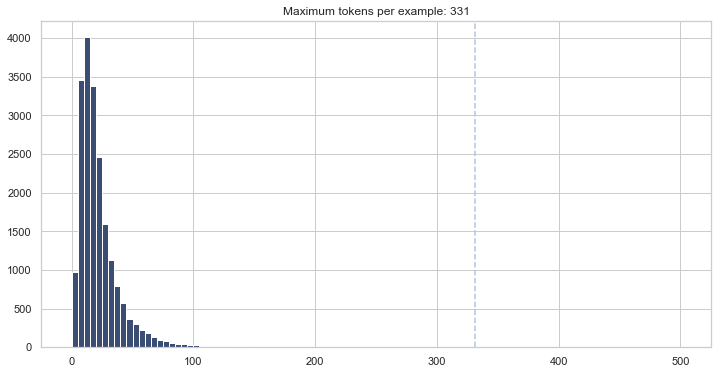

In [ ]:
import seaborn as sns
# Set the style to gradient blue
sns.set(style="whitegrid", palette="ch:r=-.2,d=.3_r")
lengths = []
plt.figure(figsize=(12, 6))


for i in range(0, len(source_texts), 1024):
    pt_examples = source_texts[i: i + 1024]
    en_examples = target_texts[i: i + 1024]

    pt_tokens = [source_tokenizer.tokenize(text) for text in pt_examples]
    pt_lengths = [len(tokens) for tokens in pt_tokens]
    lengths.append(pt_lengths)

    en_tokens = [target_tokenizer.tokenize(text) for text in en_examples]
    en_lengths = [len(tokens) for tokens in en_tokens]
    lengths.append(en_lengths)
    print(".", end="", flush=True)

all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim(), color="lightsteelblue", linestyle="--")
plt.title(f"Maximum tokens per example: {max_length}")
plt.show()

## Defining nn.Module/Optimizer

In [ ]:
import random
from typing import Tuple
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
#  the proposed model trying to generate the t-th target word yt given a source sentence (x1, x2, . . . , xT ).
# The Encoder class is responsible for processing the input sequence and generating a context vector.
class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)   #GRU do it later, see the difference
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

#  The Attention class computes an attention vector that is used to weight the importance of
# each element in the input sequence when generating the output sequence.
class Attention(nn.Module): #a single head attention
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim
        self.attn = nn.Linear(self.attn_in, attn_dim)
    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))
        attention = torch.sum(energy, dim=2)
        return F.softmax(attention, dim=1)

# The Decoder class is responsible for generating the output sequence using the context vector
# from the Encoder and the attention mechanism defined by the Attention class.
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted_encoder_rep = torch.bmm(a, encoder_outputs)
        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)
        return weighted_encoder_rep
    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)
        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)
        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0)

# The Seq2Seq class combines the Encoder and Decoder classes, defining the entire sequence-to-sequence
# model, which takes an input sequence and generates an output sequence.
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder   #Combine
        self.decoder = decoder
        self.device = device
    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        # first input to the decoder is the <sos> token
        output = trg[0,:]
        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
        return outputs

# Configuration parameters for the model
INPUT_DIM = len(source_vocab)
OUTPUT_DIM = len(target_vocab)
# ENC_EMB_DIM = 256
# DEC_EMB_DIM = 256
# ENC_HID_DIM = 512
# DEC_HID_DIM = 512
# ATTN_DIM = 64
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5
ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)
def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters()) # Define the optimizer (Adam) for training the model
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) # Function to count the number of trainable parameters in the model
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,257,150 trainable parameters


In [ ]:
PAD_IDX = target_token_to_idx['<pad>'] # ignore the indices where the target is simply padding.
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

## Train and evaluate this model

In [ ]:
import math
import time
def train(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()
    epoch_loss = 0

    for _, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for _, (src, trg) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0) #turn off teacher forcing
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')
accumulation_steps = 4  # Number of steps to accumulate gradients before updating model weights     # RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 10345503744 bytes.
                                                                                                #check batch size
for epoch in range(N_EPOCHS):
    start_time = time.time()
    optimizer.zero_grad()  # Reset gradients at the beginning of each epoch

    for step, (src, trg) in enumerate(train_iter):
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg)
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
            optimizer.step()
            optimizer.zero_grad()  # Reset gradients after updating model weights

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |') 


Epoch: 01 | Time: 86m 2s
	Train Loss: 6.838 | Train PPL: 932.216
	 Val. Loss: 6.308 |  Val. PPL: 549.012
Epoch: 02 | Time: 80m 13s
	Train Loss: 6.174 | Train PPL: 479.888
	 Val. Loss: 6.323 |  Val. PPL: 557.183
Epoch: 03 | Time: 83m 48s
	Train Loss: 6.052 | Train PPL: 424.893
	 Val. Loss: 6.284 |  Val. PPL: 536.049
Epoch: 04 | Time: 83m 29s
	Train Loss: 5.923 | Train PPL: 373.486
	 Val. Loss: 6.262 |  Val. PPL: 524.114
Epoch: 05 | Time: 82m 37s
	Train Loss: 5.822 | Train PPL: 337.764
	 Val. Loss: 6.240 |  Val. PPL: 513.049
Epoch: 06 | Time: 84m 57s
	Train Loss: 5.748 | Train PPL: 313.649
	 Val. Loss: 6.243 |  Val. PPL: 514.449
Epoch: 07 | Time: 82m 58s
	Train Loss: 5.666 | Train PPL: 289.008
	 Val. Loss: 6.280 |  Val. PPL: 533.677
Epoch: 08 | Time: 79m 48s
	Train Loss: 5.615 | Train PPL: 274.600
	 Val. Loss: 6.231 |  Val. PPL: 508.388
Epoch: 09 | Time: 81m 37s
	Train Loss: 5.564 | Train PPL: 260.734
	 Val. Loss: 6.257 |  Val. PPL: 521.795
Epoch: 10 | Time: 83m 14s
	Train Loss: 5.494 | 

In [ ]:
def translate_sentence(sentence, source_tokenizer, source_token_to_idx, source_idx_to_token, target_token_to_idx, target_idx_to_token, model, device, max_len=50):
    model.eval()

    tokens = [source_token_to_idx['<s>']] + [source_token_to_idx[token] if token in source_token_to_idx else source_token_to_idx['<unk>'] for token in source_tokenizer.tokenize(sentence)] + [source_token_to_idx['</s>']]
    src_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indices = [target_token_to_idx['<s>']]

    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == target_token_to_idx['</s>']:
            break

    trg_tokens = [target_idx_to_token[idx] for idx in trg_indices]
    return trg_tokens[1:-1]  # Remove <s> and </s> tokens

In [ ]:
source_sentence = "jri̯ [n] =[n] [m] w[ḏ].n =k nb"
translated_tokens = translate_sentence(source_sentence, source_tokenizer, source_token_to_idx, source_idx_to_token, target_token_to_idx, target_idx_to_token, model, device)
translated_sentence = " ".join(translated_tokens)
print("Source sentence:", source_sentence)
print("Translated sentence:", translated_sentence)

Source sentence: jri̯ [n] =[n] [m] w[ḏ].n =k nb
Translated sentence: &#91; § &#93; &#93; &#93; &#93; &#93; &#93; &#93; &#93; &#91; ... &#93; &#91; ... &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93; &#91; § &#93;


In [ ]:
print(target_token_to_idx)

{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '...': 4, 'die': 5, 'Neun-Bogenvölker': 6, 'zu': 7, 'ihm': 8, 'Pferdegespann': 9, '&#91;': 10, 'Pferde': 11, '&#93;': 12, ':': 13, 'Das': 14, 'erste': 15, 'große': 16, 'Pfergespann': 17, 'seiner': 18, 'Majestät': 19, '(': 20, 'namens': 21, ')': 22, '&apos;': 23, 'Groß': 24, 'an': 25, 'Siegen': 26, '.': 27, 'Gefangene': 28, 'Die': 29, 'großen': 30, 'Oberhäupter': 31, 'von': 32, 'Retjenu': 33, ',': 34, 'seine': 35, 'als': 36, 'Kriegsgefangene': 37, 'gebracht': 38, 'hat': 39, 'Worte': 40, 'sprechen': 41, 'durch': 42, 'Isis': 43, 'Große': 44, 'Gottesmutter': 45, '&quot;': 46, 'Mein': 47, 'geliebter': 48, 'Sohn': 49, 'Ramses-meriamun': 50, 'deine': 51, 'Lebenszeit': 52, 'ist': 53, 'wie': 54, 'meines': 55, 'Sohnes': 56, 'Horus': 57, 'So': 58, 'du': 59, 'bist': 60, 'so': 61, 'auch': 62, 'der': 63, 'aus': 64, 'meinem': 65, 'Leib': 66, 'herauskam': 67, '=': 68, 'Du': 69, 'nützlich': 70, 'für': 71, 'uns': 72, 'er': 73, 'selbst': 74, 'se': 75, 'des': 

In [ ]:
print(source_token_to_idx)

{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '⸢': 4, 'pḏ': 5, ',': 6, 'wt-9': 7, '⸣': 8, 'n': 9, '=': 10, 'f': 11, '&#91;': 12, '⸮': 13, 'ḥtr': 14, '?': 15, '&#93;': 16, 'm': 17, 'tp': 18, 'j': 19, 'ꜥꜣ': 20, 'ḥm': 21, 'Ꜥꜣ-nḫt': 22, 'w': 23, 'wr': 24, '.pl': 25, 'ꜥꜣi': 26, '̯': 27, 'n.w': 28, 'Rṯn': 29, 'jni': 30, 'sqr-ꜥnḫ': 31, 'ḏd-mdw': 32, 'jn': 33, 'ꜣs': 34, 't': 35, 'mw': 36, 't-nṯr': 37, 'sꜣ': 38, 'mri': 39, 'Rꜥw-msi': 40, '-sw-mri': 41, '-Jmn': 42, 'ꜥḥꜥ': 43, 'k': 44, 'mj': 45, 'Ḥr': 46, 'ḫy': 47, 'ntk': 48, 'pri': 49, 'ẖ': 50, 'ꜣḫ': 51, 'mj-qd': 52, 'pꜣ': 53, 'p': 54, 'tꜣ': 55, 'nsw': 56, 'yt': 57, 'nb-r-ḏr': 58, 'nꜣ': 59, 'rnp': 60, 't.pl': 61, 'Nb': 62, 'wj': 63, 'nswt': 64, 'st': 65, 'wḏ': 66, 't-zp': 67, '6': 68, 'ꜣbd': 69, '4': 70, 'sw': 71, '1': 72, 'ḫr': 73, 'Kꜣ-nḫt-ḫꜥ-m-Wꜣs': 74, 't-sꜥnḫ-Tꜣ': 75, 'tj': 76, '-': 77, 'nbw': 78, 'Wḥm-ḫꜥ': 79, '-wsr-pḏ': 80, 'wt-m-tꜣ': 81, 'w-nb': 82, 'nswt-bj': 83, 'nb-Tꜣ': 84, 'du': 85, 'Mn-Mꜣꜥ': 86, 't-Rꜥw': 87, 'zꜣ-Rꜥw': 88, 'nb-': 89, 